In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from astropy.stats import sigma_clip
from datetime import datetime
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(style='whitegrid')
from scipy.stats import norm
import pandas as pd
import warnings
import matplotlib.mlab as mlab
from pandas import DataFrame

### MASTER BIAS

In [3]:
pwd

'/home/jovyan/ASTR_136'

In [7]:
filedir = '/home/jovyan/ASTR_136/BIAS/Stuff'
files_bias = [os.path.join(filedir, f) for f in os.listdir(filedir)]

In [124]:
biasdata = np.zeros((510, 765, len(files_bias)))
bias_exp = np.zeros(len(files_bias))
    
for i in range(len(files_bias)):
    hdu = fits.open(files_bias[i])
    if not hdu[0].header['EXPTIME']:
        biasdata[:,:, i] = hdu[0].data
        bias_exp[i] = hdu[0].header['EXPTIME']

In [137]:
bias_mean = np.mean(biasdata,axis=(0,1))
bias_median = np.median(biasdata,axis=(0,1))
bias_std = np.std(biasdata, axis = (0,1))
bias_counts = np.sum(biasdata, axis=(0,1))
bias_count_error = np.sqrt(bias_mean)

biasdata_clipped = sigma_clip(biasdata)
bias_master = np.median(biasdata_clipped, axis=2)

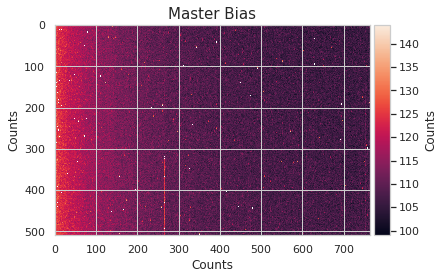

In [35]:
warnings.filterwarnings("ignore")

ax = plt.subplot(111)
im = ax.imshow(bias_master)
plt.title('Master Bias', loc= 'center', fontsize=15)
plt.xlabel('Counts')
plt.ylabel('Counts')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

### MASTER DARK

In [145]:
filedir = '/home/jovyan/ASTR_136/DARK'
files_dark = [os.path.join(filedir, f) for f in os.listdir(filedir)]
dark_data = np.zeros((510,765,len(files_dark)))
dark_exp = np.zeros(len(files_dark))

In [146]:
for i in range(len(files_dark)):
    hdu_dark = fits.open(files_dark[i])
    if hdu_dark[0].header['EXPTIME'] > 0:
        correct_dark = (hdu_dark[0].data - bias_master)/hdu_dark[0].header['EXPTIME']
        dark_data[:,:, i] = correct_dark
        dark_exp[i] = hdu_dark[0].header['EXPTIME']

In [201]:
dark_mean = np.mean(dark_data,axis=(0,1))
dark_median = np.median(dark_data,axis=(0,1))
dark_std = np.std(dark_data, axis = (0,1))
dark_counts = np.sum(dark_data, axis=(0,1))
dark_count_error = np.sqrt(dark_mean)

dark__master_clipped = sigma_clip(dark_data)
dark_master = np.median(dark_clipped, axis=2)

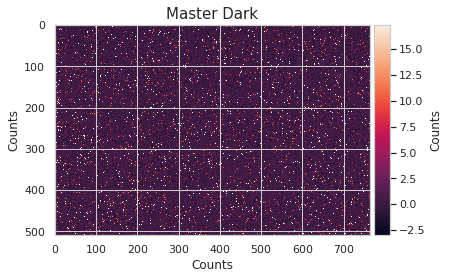

In [43]:
warnings.filterwarnings("ignore")

ax = plt.subplot(111)
im = ax.imshow(dark_master)
plt.title('Master Dark', loc= 'center', fontsize=15)
plt.xlabel('Counts')
plt.ylabel('Counts')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

### MASTER FLAT

In [160]:
filedir = '/home/jovyan/ASTR_136/TWI'
files_flat = [os.path.join(filedir, f) for f in os.listdir(filedir) if f.endswith('.fits')]
flat_exp = np.zeros(len(files_flat))

In [161]:
flat_data = [] # Load images into list
for i in range(len(files_flat)):
    hdu_flat = fits.open(files_flat[i])
    if hdu_flat[0].header['EXPTIME'] > 0 and hdu_flat[0].header['APTDIA'] > 0:
        corr_flat = (((hdu_flat[0].data - bias_master)/hdu_flat[0].header['EXPTIME']) - dark_master)
        flat_clipped = sigma_clip(corr_flat)
        flat_min = np.min(flat_clipped)
        flat_norm = (flat_clipped / flat_min)
        flat_data.append(flat_norm)
        flat_exp[i] = hdu_flat[0].header['EXPTIME']

flat_masks = [arr.mask for arr in flat_data] # Get masks for each image in flat_data
flat_data = np.ma.masked_array(data=np.dstack(flat_data), mask=np.dstack(flat_masks)) # Create stacked masked array

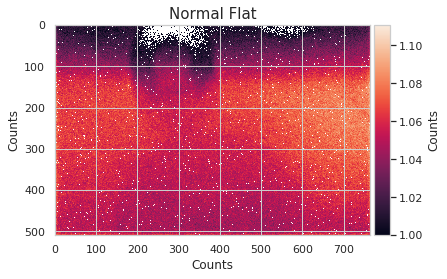

In [205]:
ax = plt.subplot(111)
im = ax.imshow(flat_norm)
plt.title('Normal Flat', loc= 'center', fontsize=15)
plt.xlabel('Counts')
plt.ylabel('Counts')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

In [207]:
flat_mean = np.mean(flat_data, axis = (0,1))
flat_median = np.median(flat_data, axis =(0,1))
flat_std = np.std(flat_data, axis = (0,1))
flat_counts = np.sum(flat_data, axis=(0,1))
flat_count_error = np.sqrt(flat_mean)

flat_master = np.median(flat_data, axis=2)

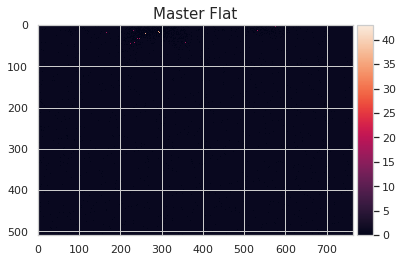

In [208]:
warnings.filterwarnings("ignore")

ax = plt.subplot(111)
im = ax.imshow(flat_master.data)
plt.title('Master Flat', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


plt.show()

### MASTER SCIENCE

In [177]:
filedir = '/home/jovyan/ASTR_136/SCIENCE'
files_science = [os.path.join(filedir, f) for f in os.listdir(filedir)if f.endswith('.fits')]

science_data = np.zeros((510, 765, len(files_science)))
science_exp = np.zeros(len(files_science))

In [178]:
obs_t_sci = []
for i in range(len(files_science)):
    hdu_sci = fits.open(files_science[i])
    header_sci = hdu_sci[0].header
    if header_sci['EXPTIME'] > 0 and header_sci['APTDIA'] > 0:
        sci_clipped = sigma_clip(hdu_sci[0].data)
        correct_sci = (((sci_clipped - bias_master) /
                             header_sci['EXPTIME']) - dark_master
                             ) / flat_master
        science_data[:,:, i] = correct_sci
        science_exp[i] = hdu_sci[0].header['EXPTIME']
            
        time = header_sci['TIME-OBS']
        obs_t_sci += [time]   #or append. Just don't split to keep it as string

In [195]:
sci_mean = np.mean(science_data, axis=(0,1))
sci_median = np.median(science_data, axis = (0,1))
sci_std = np.std(science_data, axis=(0,1))
sci_counts = np.sum(science_data, axis = (0,1))
sci_count_error = np.sqrt(sci_mean)
#science-exp

### CONVERTING TIME TO SECONDS

In [62]:
seconds = []
for i in range(len(obs_t_sci)):
    dt = datetime.strptime(obs_t_sci[i], '%H:%M:%S.%f')
    total_seconds = dt.second + dt.minute*60 + dt.hour*3600
    seconds.append(total_seconds)

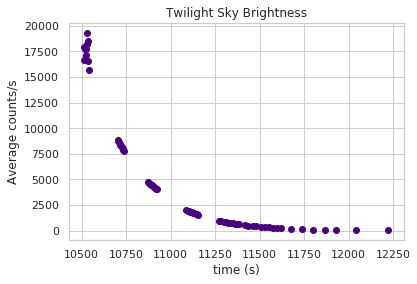

In [63]:
ax = plt.subplot(111)
plt.xlabel('time (s)') 
plt.ylabel('Average counts/s') 
plt.title('Twilight Sky Brightness')
plt.scatter(seconds, sci_median, label="projected" , color = 'indigo')
plt.show()

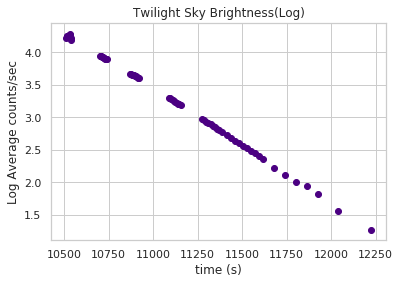

In [64]:
ax = plt.subplot(111)
y = np.log10(sci_median)
plt.xlabel('time (s)') 
plt.ylabel('Log Average counts/sec') 
plt.title('Twilight Sky Brightness(Log)')
plt.scatter(seconds, y, label="projected" , color = 'indigo')
plt.show()

### Fit The Data


In [65]:
m, b = np.polyfit(seconds, y, 1)

In [66]:
# Linear function:
def func(x,m,b):
    f = []
    for i in x:
        y_func = m*i + b
        f.append(y_func)
    return f

In [67]:
y_fit = func(seconds,m,b)

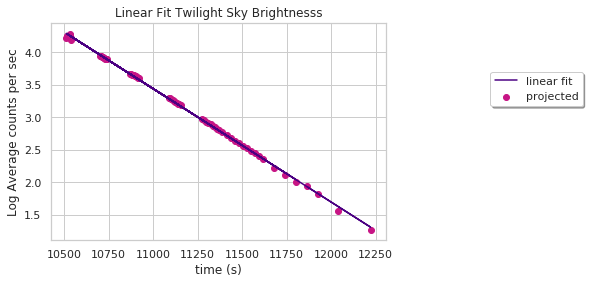

In [68]:
ax = plt.subplot(111)
plt.xlabel('time (s)') 
plt.ylabel('Log Average counts per sec') 
plt.title('Linear Fit Twilight Sky Brightnesss')
plt.scatter(seconds, y, label="projected" , color = 'mediumvioletred')
plt.plot(seconds, y_fit, label='linear fit', color='indigo')
#plt.savefig("Man.pdf")
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)

In [75]:
y_log = np.log(sci_median)
m, b = np.polyfit(seconds, y_log, 1)
def func(x,m,b):
    f = []
    for i in x:
        y_func = m*i + b
        f.append(y_func)
    return f

In [76]:
y_fit_log = func(seconds,m,b)

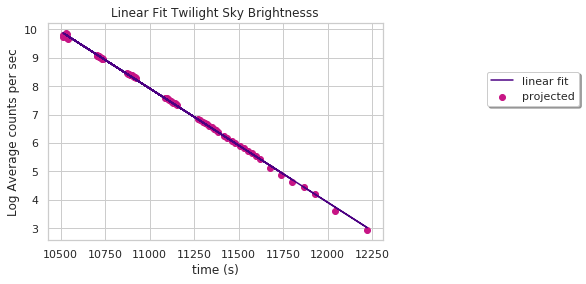

In [77]:
y_log = np.log(sci_median)
ax = plt.subplot(111)
plt.xlabel('time (s)') 
plt.ylabel('Log Average counts per sec') 
plt.title('Linear Fit Twilight Sky Brightnesss')
plt.scatter(seconds, y_log, label="projected" , color = 'mediumvioletred')
plt.plot(seconds, y_fit_log, label='linear fit', color='indigo')
#plt.savefig("Man.pdf")
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)

In [78]:
m

-0.004013000382749987

### Goodness of Fit

In [79]:
sci_std= np.array(sci_std)
sci_median = np.array(sci_median)
y = np.array(y)
y_fit = np.array(y_fit)

In [80]:
y_std = np.log10(sci_std)

In [81]:
chi_squared = np.sum((y-y_fit)/y_std)
chi_squared

0.009728070131734979

In [82]:
goodness_fit = chi_squared /(len(y)-1) #N=67 and dof=1
goodness_fit

0.00014739500199598452

### Calculating the Rotation Rate

In [83]:
B = -6.1
phi = np.radians(12)
R_0 = 6378.137 #in km
Z = 150 #in km 

u = (B*phi)*((R_0/Z))
d_phi = -0.004/u #radians/s #m is the slope from cell above
print(d_phi) 

dphi_degrees = 15.1877727891572 
 #conversion of d_phi from radians/s to degrees/hour
rotation_rate = dphi_degrees*24 #times 24 hours to see total radial change in a day
print(rotation_rate)

percent_change = rotation_rate / 360
print(percent_change)
print('rotation_calculated = 1.01rotation_true')

7.36324003376657e-05
364.5065469397728
1.0125181859438135
rotation_calculated = 1.01rotation_true


### Final Reduced Histogram

In [84]:
sample_science = science_data[:,:,60]

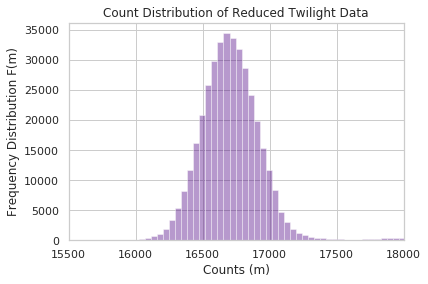

In [89]:
ax = plt.subplot(111)
ax = sns.distplot(sample_science.flatten(), bins = 550, color='indigo', kde = False)
x = np.linspace(15500, 18000, 1)
plt.plot(x, mlab.normpdf(x, mu, sigma))
plt.xlim(15500,18000)
plt.xlabel('Counts (m)') 
plt.ylabel('Frequency Distribution F(m)') 
plt.title('Count Distribution of Reduced Twilight Data')
plt.show() 

### Observations

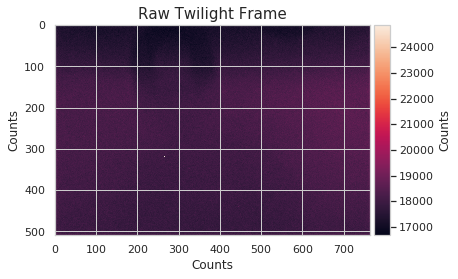

In [91]:
hdu_flat = fits.open("/home/jovyan/ASTR_136/SCIENCE/Project1_SB.00000089.fits")
example = hdu_flat[0].data

ax = plt.subplot(111)
im = ax.imshow(example)
plt.title('Raw Twilight Frame', loc= 'center', fontsize=15)
plt.xlabel('Counts')
plt.ylabel('Counts')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()



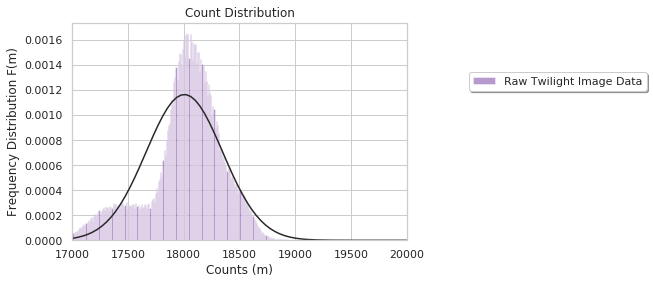

In [40]:
ax = sns.distplot(example.flatten(), fit = norm, bins = 'fd', color='indigo',kde=False, hist_kws={"label":"Raw Twilight Image Data"},kde_kws={"label":"Gaussian"})
plt.xlim(17000,20000)
plt.xlabel('Counts (m)') 
plt.ylabel('Frequency Distribution F(m)') 
plt.title('Count Distribution')
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.show() 



### Make Tables of Data

In [199]:
bias = DataFrame(np.stack((bias_mean.flatten(), bias_median.flatten(),
bias_std.flatten(),bias_counts.flatten(),bias_count_error.flatten(),bias_exp.flatten())).T, 
                 columns = ('Means(Counts)', 'Medians(Counts)', 
                            'Standard Dev(Counts)',' Total Counts','Count Error','Exposure Time'))

In [200]:
#bias.to_latex()

In [202]:
dark = DataFrame(np.stack((dark_mean.flatten(), dark_median.flatten(), 
dark_std.flatten(),dark_counts.flatten(),dark_count_error.flatten(),dark_exp.flatten())).T, 
columns = ('Means(Counts)', 'Medians(Counts)', 'Standard Dev(Counts)'
           ,'Total Counts', 'Count Error','Exposure Time(s)'))

In [206]:
flat = DataFrame(np.stack((flat_mean.flatten(), flat_median.flatten(), 
flat_std.flatten(),flat_counts.flatten(), flat_count_error.flatten(),flat_exp.flatten())).T, 
columns = ('Means', 'Medians', 'Standard Dev', 'Master Flat Counts','Count Error','Exposure Time (s)'))

In [209]:
science = DataFrame(np.stack((sci_mean.flatten(), sci_median.flatten(), 
sci_std.flatten(),sci_counts.flatten(), 
                          sci_count_error.flatten(),science_exp.flatten())).T, 
columns = ('Means', 'Medians', 'Standard Dev', 
           'Total Counts','Count Error','Exposure Time (s)'))